# Bird Collision Dataset Summary Generator

### Brief overview of the script

1. We first accept the inputDir and outputDir as inputs to the script. These arguments will tells us where to read the JSONs and write the resulting CSVs. If you are planning to run this script, please specify inputDir and outputDir below.


2. Then, we check if the JSON files in the directory are valid JSON files. Once done evaluating that, we check if there are missing serial numbers in the JSON which might to some missing rows in the table we will generate.


3. Next, we create dataframe objects using the JSONs which would in `df_lightLevels`, `df_flightCall` and `df_chicagoCollisionData`.


4. Some of the column names in the dataframes need to be fixed which happens in this step.


5. Next, we delete duplicated rows in `df_lightLevels` and `df_flightCall` dataframes. We do NOT delete duplicate in `df_chicagoCollisionData` since each row in this dataframe is an occurence of collision.


6. Next, we examine the null values in the three dataframes, if any. `df_chicagoCollisionData` and `df_flightCall` have no nulls in any of their columns. However, `df_lightLevels` has nulls values under both the `Date` and `Light Score` columns.


7. Next, we examine for unique values under the columns of all the dataframes. This is where we clean up text by fixing the case of the text values, leading or trailing whitespace in the text values, fix repeated values or incorrectly spelled values and so on.


8. Next, we try to drop null values of `df_lightLevels` since knowing the light scores without their dates is not useful.


9. Finally, we combine the information in `df_chicagoCollisionData` and `df_lightLevels` by performing the left join on the `Date` column in the resulting dataframe.


10. Next, we take the resulting dataframe of the previous step as the left table and `df_flightCall` as right table and perform left join on the column names `Genus` and `Species`. This will give the final fully joined dataframe `df_fullDataJoined`.


11. After joining, we see that 89 rows are still missing information for columns `Family`, `Collisions`, `Flight Call`, `Habitat`, `Stratum`. We lookup information and fill them in. 


12. The values under `Collisions` are still unfilled. This step handles that. 


13. Finally, we perform a group by operation to group by the columns **`Family`, `Genus`, `Species`** and aggregate values under other columns except Date column since aggregate of different date values is meaningless.


14. Finally, we save the dataframe as a CSV file named **summary_table.csv** in the output directory specified in the script. Along with it, we can also save `df_fullDataJoined` as **fullDataJoined_table.csv**.

### <font color='red'> 1. We first accept the inputDir and outputDir as inputs to the script. These arguments will tells us where to read the JSONs and write the resulting CSVs. </font>

In [1]:
# import libraries

import os, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loads paths to JSON files

# inputDir, outputDir = sys.argv[1], sys.argv[2]
inputDir = 'data' # user to input
outputDir = 'result' # # user to input

jsonFile_lightLevels = os.path.join(inputDir, 'light_levels.json')
jsonFile_flightCall = os.path.join(inputDir, 'flight_call.json')
jsonFile_chicagoCollisionData = os.path.join(inputDir, 'chicago_collision_data.json')

### 2. <font color='red'> Then, we check if the JSON files in the directory are valid JSON files. Once done evaluating that, we check if there are missing serial numbers in the JSON which might to some missing rows in the table we will generate.

In [3]:
# check if jsonFiles are valid json files

jsonFileValidities = [
    utils.isValidJsonFile(jsonFile_lightLevels),
    utils.isValidJsonFile(jsonFile_flightCall),
    utils.isValidJsonFile(jsonFile_chicagoCollisionData)
]

if all(jsonFileValidities) == True:
    print("All files are valid JSON files.")

# check if records under each key in each JSON file have issues in serial numbering
recordSerialNumberValidities = [
    utils.checkSerialNumbersInJsonFile(jsonFile_lightLevels),
    utils.checkSerialNumbersInJsonFile(jsonFile_flightCall),
    utils.checkSerialNumbersInJsonFile(jsonFile_chicagoCollisionData)
]

if all(recordSerialNumberValidities) == True:
    print("All files have valid record serial numbers across their all their keys.")

All files are valid JSON files.
All files have valid record serial numbers across their all their keys.


### <font color='red'> 3. Next, we create dataframe objects using the JSONs which would in `df_lightLevels`, `df_flightCall` and `df_chicagoCollisionData`. </font>

In [4]:
df_lightLevels = pd.read_json(jsonFile_lightLevels)
df_flightCall = pd.read_json(jsonFile_flightCall)
df_chicagoCollisionData = pd.read_json(jsonFile_chicagoCollisionData)

### <font color='red'> 4. Some of the column names in the dataframes need to be fixed. </font>

In [5]:
# we're given that df_flightCall has incorrect column names in the problem statement itself

df_flightCall.rename(columns = {
    "Species": "Genus", # given in problem statement
    "Family": "Species", # given in problem statement
    "Collisions": "Family", # given in problem statement
    "Call": "Flight Call", # given in problem statement
    "Flight": "Collisions" # found this in supplemental material -- Table S1, explained later
}, inplace=True)

# Supplemental material: 
# https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frspb.2019.0364&file=rspb20190364supp1.pdf


df_lightLevels.rename(columns={
    "Light Score ": "Light Score" # remove the extra space in df_lightLevels['Light Score ']
}, inplace=True)

### <font color='red'> 5. Next, we delete duplicated rows in `df_lightLevels` and `df_flightCall` dataframes. We do NOT delete duplicate in `df_chicagoCollisionData` since each row in this dataframe is an occurence of collision.

In [6]:
# repeated data in df_flightCall and df_lightLevels is not useful and can interfere with our joins
df_flightCall = df_flightCall.drop_duplicates()
df_lightLevels = df_lightLevels.drop_duplicates()

### 6. Next, we examine the null values in the three dataframes. 

In [7]:
df_flightCall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genus        91 non-null     object
 1   Species      91 non-null     object
 2   Family       91 non-null     object
 3   Collisions   91 non-null     int64 
 4   Flight Call  91 non-null     object
 5   Habitat      91 non-null     object
 6   Stratum      91 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.7+ KB


In [8]:
# another way to confirm the same - the following code returns the number of null values in the whole dataframe

df_flightCall.isnull().values.sum()

0

In [9]:
df_chicagoCollisionData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Genus     69784 non-null  object        
 1   Species   69784 non-null  object        
 2   Date      69784 non-null  datetime64[ns]
 3   Locality  69784 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.7+ MB


In [10]:
# another way to confirm the same - the following code returns the number of null values in the whole dataframe

df_chicagoCollisionData.isnull().values.sum()

0

In [11]:
df_lightLevels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090 entries, 0 to 3250
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3081 non-null   datetime64[ns]
 1   Light Score  3075 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 72.4 KB


In [12]:
# another way to confirm the same - the following code returns the number of null values in the whole dataframe

df_lightLevels.isnull().values.sum()

24

### `df_chicagoCollisionData` and `df_flightCall` have no nulls in any of their columns. 

### However, `df_lightLevels` has nulls values under both the `Date` and `Light Score` columns.

### <font color='red'> 7. Next, we examine for unique values in the columns of all the dataframes. </font>

In [13]:
df_lightLevels.nunique()

Date           3062
Light Score      15
dtype: int64

In [14]:
df_flightCall.nunique()

Genus          52
Species        84
Family         15
Collisions     81
Flight Call     5
Habitat         6
Stratum         3
dtype: int64

In [15]:
df_chicagoCollisionData.nunique()

Genus         43
Species       84
Date        5318
Locality       2
dtype: int64

### check for unique values on some of the columns where we can investigate. 

### This is where we clean up text by fixing the case of the text values, leading or trailing whitespace in the text values, fix repeated values or incorrectly spelled values and so on.

In [16]:
pd.unique(df_lightLevels['Light Score']) # NaN values, values upto 17 i.e. the no. of windows lit up

array([ 4.,  6., nan, 15., 14.,  3., 12., 13., 17., 16.,  7., 11.,  8.,
       10.,  5.,  9.])

In [17]:
print(sorted(pd.unique(df_flightCall['Genus']))) # repeats due to casing

['Ammodramus', 'Ammospiza', 'Cardellina', 'Catharus', 'Centronyx', 'Certhia', 'Cistothorus', 'Contopus', 'Empidonax', 'Geothlypis', 'Hylocichla', 'Icterus', 'Junco', 'Lanius', 'Melospiza', 'Mniotilta', 'Myiarchus', 'Oporornis', 'Oreothlypis', 'Parkesia', 'Passerculus', 'Passerella', 'Passerina', 'Pheucticus', 'Pipilo', 'Piranga', 'Polioptila', 'Pooecetes', 'Protonotaria', 'Regulus', 'Sayornis', 'Seiurus', 'Setophaga', 'Sitta', 'Spizella', 'Spizelloides', 'Sturnella', 'Toxostoma', 'Troglodytes', 'Tyrannus', 'Vermivora', 'Vireo', 'Zonotrichia', 'catharus', 'cistothorus', 'dumetella', 'geothlypis', 'icteria', 'setophaga', 'troglodytes', 'vireo', 'zonotrichia']


**^^ We see repeat of `'catharus', 'cistothorus', ... 'vireo', 'zonotrichia'` in lower case. Also, since these are Genus part of scientific name, the first letter of all words must be uppercase. This will also fix our issue of repeats due to lower case we just mentioned.**

In [18]:
print(sorted(pd.unique(df_flightCall['Species']))) # unique values seen (all lower case)

['aedon', 'agilis', 'albicollis', 'americana', 'arborea', 'aurocapilla', 'caerulea', 'caerulescens', 'calendula', 'canadensis', 'carolinensis', 'castanea', 'celata', 'cerulea', 'chrysoptera', 'citrea', 'citrina', 'cooperi', 'coronata', 'crinitus', 'cyanea', 'cyanoptera', 'erythrophthalmus', 'excubitor', 'flavifrons', 'flaviventris', 'formosa', 'fusca', 'fuscescens', 'galbula', 'georgiana', 'gilvus', 'gramineus', 'guttatus', 'henslowii', 'hiemalis', 'hyemalis', 'iliaca', 'leconteii', 'leucophrys', 'lincolnii', 'ludovicianus', 'magna', 'magnolia', 'melodia', 'minimus', 'motacilla', 'mustelina', 'nelsoni', 'noveboracensis', 'olivacea', 'olivaceus', 'pallida', 'palmarum', 'palustris', 'passerina', 'pensylvanica', 'peregrina', 'petechia', 'philadelphia', 'philadelphicus', 'phoebe', 'pinus', 'platensis', 'pusilla', 'querula', 'rubra', 'ruficapilla', 'rufum', 'ruticilla', 'sandwichensis', 'satrapa', 'savannarum', 'solitarius', 'spurius', 'striata', 'tigrina', 'traillii', 'trichas', 'tyrannus'

**^^ The Species part of the scientific name (consists of Genus and species parts, in this order) needs to start with the lower letter. Hence, we need not change anything here. Also, we do not see any repeats due to casing here.**

In [19]:
print(sorted(pd.unique(df_flightCall['Family']))) # ['Icteridae', 'Icteriidae', ...] - spelling issue

['Cardinalidae', 'Certhiidae', 'Icteridae', 'Icteriidae', 'Laniidae', 'Mimidae', 'Parulidae', 'Passerellidae', 'Polioptilidae', 'Regulidae', 'Sittidae', 'Troglodytidae', 'Turdidae', 'Tyrannidae', 'Vireonidae']


**^^ we see there is a mistake in the spelling for the Icteridae family**

In [20]:
print(sorted(pd.unique(df_flightCall['Flight Call'])))

['No', 'Rare', 'Yes', 'no', 'yes']


**^^ changing the casing to lower case and changing the Rare to 'no' will fix this issue. We change 'Rare' to 'no' since the paper makes this assumption**

In [21]:
print(sorted(pd.unique(df_flightCall['Habitat'])))

['Edge', 'Forest', 'Open', 'edge', 'forest', 'open']


**^^ changing the casing to lower case should solve this issue**

In [22]:
print(sorted(pd.unique(df_flightCall['Stratum'])))

['Lower', 'Lower\t', 'Upper']


**^^ stripping leading and trailing whitespaces should fix this issue**

In [23]:
print(sorted(pd.unique(df_chicagoCollisionData['Genus']))) # unique values seen (all in title case)

['Ammodramus', 'Cardellina', 'Catharus', 'Certhia', 'Cistothorus', 'Contopus', 'Dumetella', 'Empidonax', 'Geothlypis', 'Hylocichla', 'Icteria', 'Icterus', 'Junco', 'Lanius', 'Melospiza', 'Mniotilta', 'Myiarchus', 'Oporornis', 'Oreothlypis', 'Parkesia', 'Passerculus', 'Passerella', 'Passerina', 'Pheucticus', 'Pipilo', 'Piranga', 'Polioptila', 'Pooecetes', 'Protonotaria', 'Regulus', 'Sayornis', 'Seiurus', 'Setophaga', 'Sitta', 'Spizella', 'Spizelloides', 'Sturnella', 'Toxostoma', 'Troglodytes', 'Tyrannus', 'Vermivora', 'Vireo', 'Zonotrichia']


In [24]:
print(sorted(pd.unique(df_chicagoCollisionData['Species']))) # unique values seen (lower case)

['aedon', 'agilis', 'albicollis', 'americana', 'arborea', 'aurocapilla', 'caerulea', 'caerulescens', 'calendula', 'canadensis', 'carolinensis', 'castanea', 'celata', 'cerulea', 'chrysoptera', 'citrea', 'citrina', 'cooperi', 'coronata', 'crinitus', 'cyanea', 'cyanoptera', 'erythrophthalmus', 'excubitor', 'flavifrons', 'flaviventris', 'formosa', 'fusca', 'fuscescens', 'galbula', 'georgiana', 'gilvus', 'gramineus', 'guttatus', 'henslowii', 'hiemalis', 'hyemalis', 'iliaca', 'leconteii', 'leucophrys', 'lincolnii', 'ludovicianus', 'magna', 'magnolia', 'melodia', 'minimus', 'motacilla', 'mustelina', 'nelsoni', 'noveboracensis', 'olivacea', 'olivaceus', 'pallida', 'palmarum', 'palustris', 'passerina', 'pensylvanica', 'peregrina', 'petechia', 'philadelphia', 'philadelphicus', 'phoebe', 'pinus', 'platensis', 'pusilla', 'querula', 'rubra', 'ruficapilla', 'rufum', 'ruticilla', 'sandwichensis', 'satrapa', 'savannarum', 'solitarius', 'spurius', 'striata', 'tigrina', 'traillii', 'trichas', 'tyrannus'

In [25]:
print(sorted(pd.unique(df_chicagoCollisionData['Locality']))) # unique values seen

['CHI', 'MP']


### next, we make all the changes that will fix the issues we identified

In [26]:
# change 'rare' under df_flightCall['Flight Call'] to 'no' since the paper makes this assumption
df_flightCall['Flight Call'] = df_flightCall['Flight Call'].replace('Rare', 'no')

In [27]:
# changed Icteriidae to Icteridae, after verification on Google
df_flightCall['Family'] = df_flightCall['Family'].replace('Icteriidae', 'Icteridae')

In [28]:
# fix casing

df_flightCall['Genus'] = df_flightCall['Genus'].apply(utils.changeToTitleCase)
df_chicagoCollisionData['Genus'] = df_chicagoCollisionData['Genus'].apply(utils.changeToTitleCase)
df_flightCall['Flight Call'] = df_flightCall['Flight Call'].apply(utils.changeToLowerCase)
df_flightCall['Habitat'] = df_flightCall['Habitat'].apply(utils.changeToLowerCase)
df_flightCall['Stratum'] = df_flightCall['Stratum'].apply(utils.changeToLowerCase)

### <font color="red" > 8. Next, we try to fix the null values in `df_lightLevels` </font>  

In [29]:
# we drop null values of `df_lightLevels` since knowing the light scores without their dates is not useful.

df_lightLevels = df_lightLevels.dropna(subset=['Date'])

In [30]:
# next, we drop dates that occur twice under the dates column. By keeping the first occurence and 
# dropping subsequent occurences, we do not attempt to actively pick the highest light score for repeating dates.

df_lightLevels = df_lightLevels.drop_duplicates(subset='Date', keep='first')

In [31]:
# we also change the datatype under df_lightLevels['Light Score'] to Int16

df_lightLevels['Light Score'] = df_lightLevels['Light Score'].astype('Int16')

### With the remaining valid values in the `Date` column, we extract information like day of week, day of month, day of year, week of year, month, seasons, quarter, year and try to look for trends using them. 

In [32]:
# before we do so, we need to add Seasons information

# https://seasonsyear.com/USA/Illinois/Chicago
Seasons_dict = {
    1: 0, 2: 0, 12: 0, # 0 = Winter
    3: 1, 4: 1, 5: 1,  # 1 = Spring
    6: 2, 7: 2, 8: 2,  # 2 = Summer
    9: 3, 10: 3, 11: 3  # 3 = Fall or Autumn
}

In [33]:
df_lightLevels_temp = df_lightLevels.copy()

df_lightLevels_temp["Day of week"] = df_lightLevels_temp["Date"].dt.dayofweek # 0 = Monday, 6 = Sunday
df_lightLevels_temp["Day of month"] = df_lightLevels_temp["Date"].dt.day
df_lightLevels_temp["Day of year"] = df_lightLevels_temp["Date"].dt.dayofyear
df_lightLevels_temp["Week of year"] = df_lightLevels_temp["Date"].dt.weekofyear

df_lightLevels_temp["Month"] = df_lightLevels_temp["Date"].dt.month
df_lightLevels_temp["Season"] = df_lightLevels_temp["Date"].dt.month.apply(lambda val: Seasons_dict[val])
df_lightLevels_temp["Quarter"] = df_lightLevels_temp["Date"].dt.quarter
df_lightLevels_temp["Year"] = df_lightLevels_temp["Date"].dt.year

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [34]:
df_lightLevels_temp

,Date,Light Score,Day of week,Day of month,Day of year,Week of year,Month,Season,Quarter,Year
0,2010-09-26,4,6,26,269,38,9,3,3,2010
1,2015-05-07,6,3,7,127,19,5,1,2,2015
2,2012-03-07,<NA>,2,7,67,10,3,1,1,2012
3,2000-09-18,15,0,18,262,38,9,3,3,2000
4,2000-11-10,15,4,10,315,45,11,3,4,2000
...,...,...,...,...,...,...,...,...,...,...
3246,2018-05-03,14,3,3,123,18,5,1,2,2018
3247,2001-11-07,3,2,7,311,45,11,3,4,2001
3248,2012-09-03,17,0,3,247,36,9,3,3,2012
3249,2002-03-23,3,5,23,82,12,3,1,1,2002


We also check if the time part of the datetime column brings in variance to the data.

In [35]:
# Unique time occurences in the df_lightLevels['Date'] column

print(pd.unique(df_lightLevels['Date'].dt.time))

[datetime.time(0, 0)]


In [36]:
# Unique time occurences in the df_chicagoCollisionData['Date'] column

print(pd.unique(df_chicagoCollisionData['Date'].dt.time))

[datetime.time(0, 0)]


**^^ So, we see time component of the datetime column does not contribute in anyway.**

### Let us see if we can find trends in `Light Score` variable and between time and `Light Score` variable.

/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

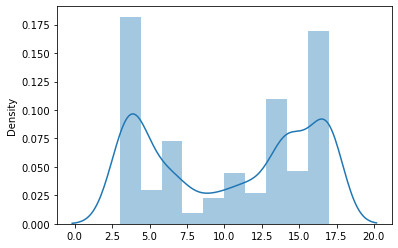

In [37]:
# extract Light Score values from rows where it is not null

y = df_lightLevels_temp[df_lightLevels_temp["Light Score"].isnull() == False].loc[:, "Light Score"].to_list()

sns.distplot(y) # observe the distribution of values for Light Score variable

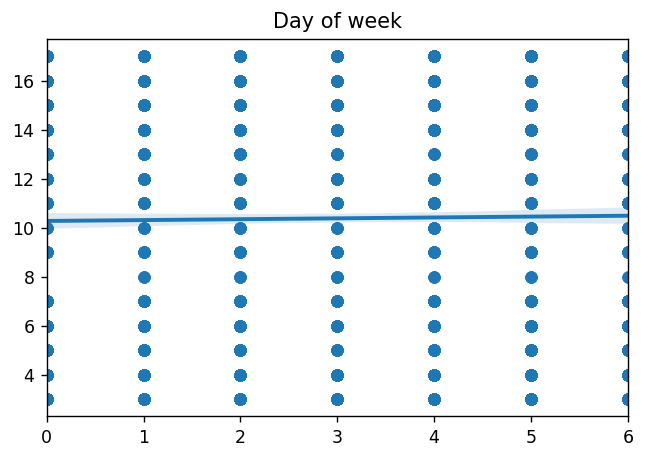

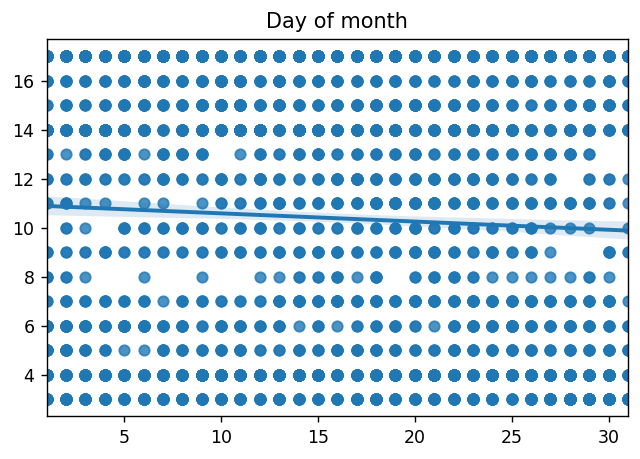

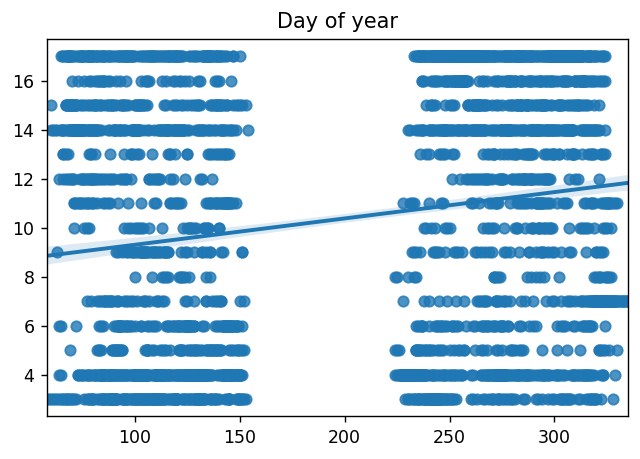

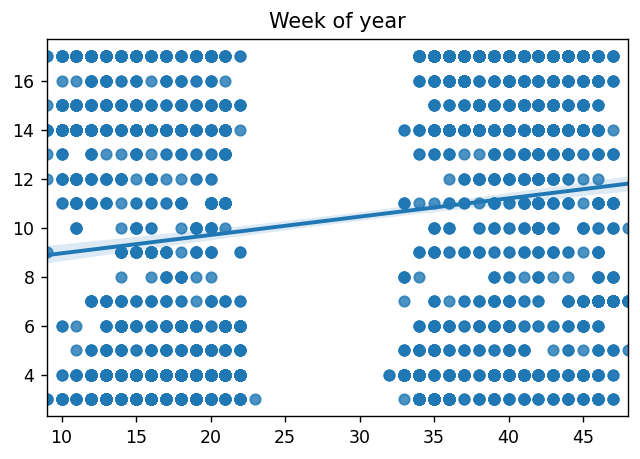

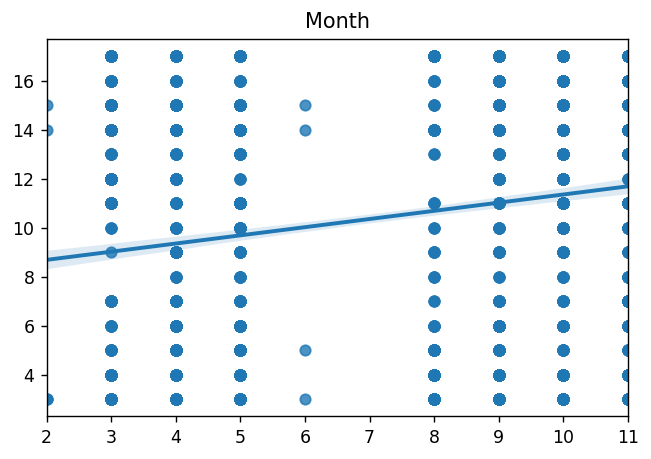

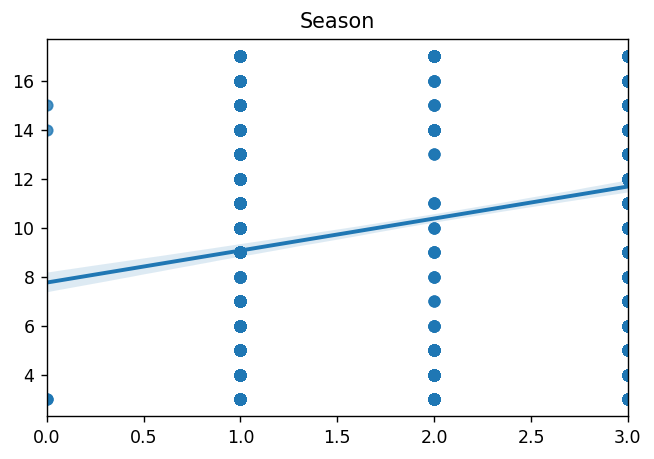

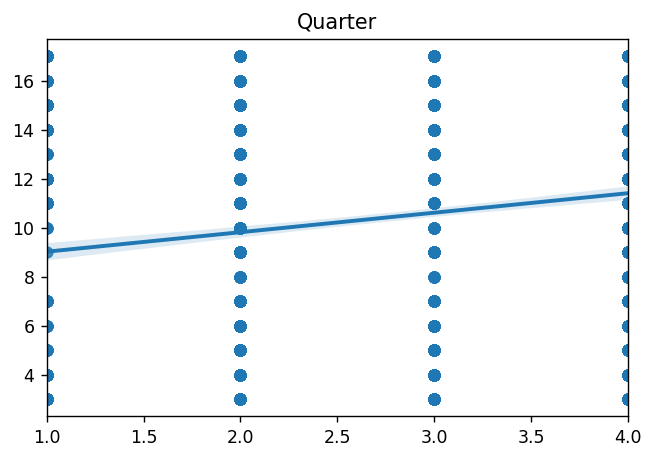

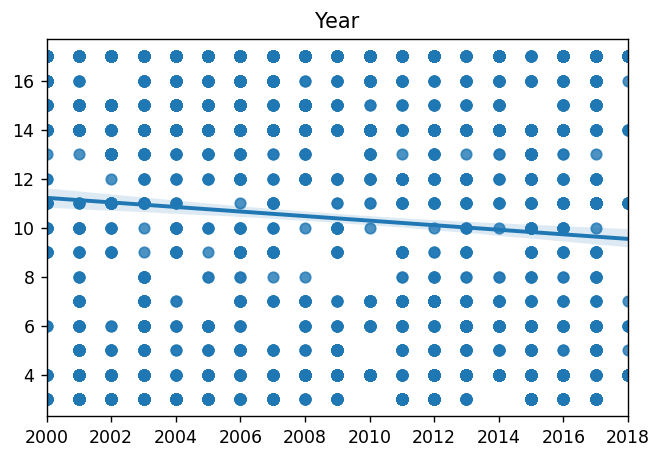

In [38]:
size = 6 # of one plot

x_vars = ["Day of week", "Day of month", "Day of year", "Week of year", "Month", "Season", "Quarter", "Year"]

for ix, columnName in enumerate(x_vars):
    x = df_lightLevels_temp[df_lightLevels_temp["Light Score"].isnull() == False].loc[:, columnName].to_list()
    
    plt.figure(dpi=125) # width, height of whole plot
    plt.subplot()
    # plt.scatter(x, y)
    sns.regplot(x=x, y=y)
    plt.title(columnName)

**^^ Looking at the Season, Week-of-year, Day-of-year plots, we observe that the collisions drastically reduce during the months of Winter(0), Summer(2) i.e. when the migration of birds in not happens. This is in line with the common knowledge that birds migrate in during Spring and away as Autumn/Fall approaches**

### ^^ looking at the trends, we cannot reliably impute the missing values under the `df_lightLevels['Light Score']`

### <font color='red'> 9. We perform a left join between `df_chicagoCollisionData` and `df_lightLevels` on the column `Date` in the two dataframes </font>

In [39]:
df_chicagoCollisionData_LJOIN_lightLevels = df_chicagoCollisionData.merge(df_lightLevels, how='left', on='Date')

In [40]:
df_chicagoCollisionData_LJOIN_lightLevels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Genus        69784 non-null  object        
 1   Species      69784 non-null  object        
 2   Date         69784 non-null  datetime64[ns]
 3   Locality     69784 non-null  object        
 4   Light Score  40847 non-null  Int16         
dtypes: Int16(1), datetime64[ns](1), object(3)
memory usage: 2.9+ MB


In [41]:
df_chicagoCollisionData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Genus     69784 non-null  object        
 1   Species   69784 non-null  object        
 2   Date      69784 non-null  datetime64[ns]
 3   Locality  69784 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.7+ MB


## same no. of rows in the resulting table as the left table means all the duplicates in the right table have been cleaned

### <font color='red'> 10. Next, we take the `df_chicagoCollisionData_LJOIN_lightLevels` as the left table and `df_flightCall` as right table and perform left join on the column names `Genus` and `Species`. </font>
    
### We chose Genus and Species becuase these two constitute a scientific name for each species/type of bird (Source: Paper, Wikipedia)

In [42]:
# gives final fully joined dataframe 

df_fullDataJoined = df_chicagoCollisionData_LJOIN_lightLevels.merge(df_flightCall, how='left', on=['Genus', 'Species'])

In [43]:
df_fullDataJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Genus        69784 non-null  object        
 1   Species      69784 non-null  object        
 2   Date         69784 non-null  datetime64[ns]
 3   Locality     69784 non-null  object        
 4   Light Score  40847 non-null  Int16         
 5   Family       69695 non-null  object        
 6   Collisions   69695 non-null  float64       
 7   Flight Call  69695 non-null  object        
 8   Habitat      69695 non-null  object        
 9   Stratum      69695 non-null  object        
dtypes: Int16(1), datetime64[ns](1), float64(1), object(7)
memory usage: 5.5+ MB


## again, same no. of rows in the resulting table as the left table means all the duplicates in the right table have been cleaned

### <font color='red'> 11. After joining, we see that 89 rows are still missing information for columns `Family`, `Collisions`, `Flight Call`, `Habitat`, `Stratum`. 

In [44]:
df_fullDataJoined

,Genus,Species,Date,Locality,Light Score,Family,Collisions,Flight Call,Habitat,Stratum
0,Ammodramus,nelsoni,1982-10-03,MP,<NA>,NaN,NaN,NaN,NaN,NaN
1,Ammodramus,nelsoni,1984-05-21,CHI,<NA>,NaN,NaN,NaN,NaN,NaN
2,Ammodramus,nelsoni,1984-05-25,MP,<NA>,NaN,NaN,NaN,NaN,NaN
3,Ammodramus,nelsoni,1985-10-08,MP,<NA>,NaN,NaN,NaN,NaN,NaN
4,Ammodramus,nelsoni,1986-09-10,MP,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
69779,Melospiza,melodia,2016-10-19,CHI,10,Passerellidae,5124.0,yes,edge,lower
69780,Melospiza,melodia,2016-10-30,CHI,3,Passerellidae,5124.0,yes,edge,lower
69781,Zonotrichia,querula,2007-10-15,MP,14,Passerellidae,2.0,yes,edge,lower
69782,Zonotrichia,querula,2008-10-16,MP,4,Passerellidae,2.0,yes,edge,lower


These missing values are seen because `df_flightCall` dataframe does not have these rows. We lookup information about the **Genus** and **Species** together i.e. the scientific name, and can find out what family a Genus-Species row belongs to, whether make **Flight Call**, what their **Habitat** is and the **Stratum** they fly in. 

In [45]:
pd.unique(df_fullDataJoined[df_fullDataJoined['Family'].isnull()]['Genus'])

array(['Ammodramus'], dtype=object)

In [46]:
pd.unique(df_fullDataJoined[df_fullDataJoined['Family'].isnull()]['Species'])

array(['nelsoni', 'henslowii', 'leconteii'], dtype=object)

In [47]:
# a simple google search tells us that ammodramus genus belongs to Passerellidae family

# replace null values in the df_fullDataJoined['Family']
df_fullDataJoined["Family"].loc[df_fullDataJoined["Genus"] == "Ammodramus"] = "Passerellidae"

/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
# next, we populate flight call, habitat, stratum based on the Genus name since we could not 
# find specific info about Ammodramus nelsoni, Ammodramus henslowii, Ammodramus leconteii

df_fullDataJoined["Flight Call"].loc[df_fullDataJoined["Genus"] == "Ammodramus"] = "yes"
df_fullDataJoined["Habitat"].loc[df_fullDataJoined["Genus"] == "Ammodramus"] = "open"
df_fullDataJoined["Stratum"].loc[df_fullDataJoined["Genus"] == "Ammodramus"] = "lower"

In [49]:
df_fullDataJoined # we can see the changes we have made here compared to the above table

,Genus,Species,Date,Locality,Light Score,Family,Collisions,Flight Call,Habitat,Stratum
0,Ammodramus,nelsoni,1982-10-03,MP,<NA>,Passerellidae,NaN,yes,open,lower
1,Ammodramus,nelsoni,1984-05-21,CHI,<NA>,Passerellidae,NaN,yes,open,lower
2,Ammodramus,nelsoni,1984-05-25,MP,<NA>,Passerellidae,NaN,yes,open,lower
3,Ammodramus,nelsoni,1985-10-08,MP,<NA>,Passerellidae,NaN,yes,open,lower
4,Ammodramus,nelsoni,1986-09-10,MP,<NA>,Passerellidae,NaN,yes,open,lower
...,...,...,...,...,...,...,...,...,...,...
69779,Melospiza,melodia,2016-10-19,CHI,10,Passerellidae,5124.0,yes,edge,lower
69780,Melospiza,melodia,2016-10-30,CHI,3,Passerellidae,5124.0,yes,edge,lower
69781,Zonotrichia,querula,2007-10-15,MP,14,Passerellidae,2.0,yes,edge,lower
69782,Zonotrichia,querula,2008-10-16,MP,4,Passerellidae,2.0,yes,edge,lower


In [50]:
df_fullDataJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Genus        69784 non-null  object        
 1   Species      69784 non-null  object        
 2   Date         69784 non-null  datetime64[ns]
 3   Locality     69784 non-null  object        
 4   Light Score  40847 non-null  Int16         
 5   Family       69784 non-null  object        
 6   Collisions   69695 non-null  float64       
 7   Flight Call  69784 non-null  object        
 8   Habitat      69784 non-null  object        
 9   Stratum      69784 non-null  object        
dtypes: Int16(1), datetime64[ns](1), float64(1), object(7)
memory usage: 5.5+ MB


### the only null values are under `df_fullDataJoined['Collisions']` and `df_fullDataJoined['Light Score']`

### The 69784 - 69695 = 89 values under  `df_fullDataJoined['Collisions']` still remain.

### <font color='red'> 12. The values under `Collisions` column are the same "number of rows" in `df_fullDataJoined` for given `(Family, Genus, Species)` tuple. Therefore, we can just count the number of rows in `df_fullDataJoined` for the tuple and fill in the NA values under `Collisions`. </font>

For example,

In [51]:
df_fullDataJoined[(df_fullDataJoined["Genus"] == "Melospiza") & (df_fullDataJoined["Species"] == "melodia")]

,Genus,Species,Date,Locality,Light Score,Family,Collisions,Flight Call,Habitat,Stratum
64657,Melospiza,melodia,1978-10-24,MP,<NA>,Passerellidae,5124.0,yes,edge,lower
64658,Melospiza,melodia,1979-04-13,MP,<NA>,Passerellidae,5124.0,yes,edge,lower
64659,Melospiza,melodia,1979-08-31,MP,<NA>,Passerellidae,5124.0,yes,edge,lower
64660,Melospiza,melodia,1979-09-06,MP,<NA>,Passerellidae,5124.0,yes,edge,lower
64661,Melospiza,melodia,1979-10-09,MP,<NA>,Passerellidae,5124.0,yes,edge,lower
...,...,...,...,...,...,...,...,...,...,...
69776,Melospiza,melodia,2016-10-02,CHI,4,Passerellidae,5124.0,yes,edge,lower
69777,Melospiza,melodia,2016-10-08,CHI,17,Passerellidae,5124.0,yes,edge,lower
69778,Melospiza,melodia,2016-10-19,CHI,10,Passerellidae,5124.0,yes,edge,lower
69779,Melospiza,melodia,2016-10-19,CHI,10,Passerellidae,5124.0,yes,edge,lower


**^^ gives 5124 rows which is same as all values under Collisions for this type of bird**

In [52]:
df_fullDataJoined[(df_fullDataJoined["Genus"] == "Zonotrichia") & (df_fullDataJoined["Species"] == "querula")]

,Genus,Species,Date,Locality,Light Score,Family,Collisions,Flight Call,Habitat,Stratum
69781,Zonotrichia,querula,2007-10-15,MP,14,Passerellidae,2.0,yes,edge,lower
69782,Zonotrichia,querula,2008-10-16,MP,4,Passerellidae,2.0,yes,edge,lower


**^^ gives 2 rows which is same as all values under Collisions for this type of bird**

### This was the reason behind renaming the column from `Flight` to `Collisions`

### Count the no. of rows for each Family-Genus-species tuple and assign that as the value under `df_fullDataJoined['Collisions']` for that tuple. 

In [53]:
# we find out the ones we need to do it for

df_missingCollisions = df_fullDataJoined[df_fullDataJoined["Collisions"].isnull()]

In [54]:
pd.unique(df_missingCollisions["Family"])

array(['Passerellidae'], dtype=object)

In [55]:
pd.unique(df_missingCollisions["Genus"])

array(['Ammodramus'], dtype=object)

In [56]:
pd.unique(df_missingCollisions["Species"])

array(['nelsoni', 'henslowii', 'leconteii'], dtype=object)

So, we have to do it for `("Passerellidae", "Ammodramus", "nelsoni")`, `("Passerellidae", "Ammodramus", "henslowii")` and `("Passerellidae", "Ammodramus", "leconteii")`

In [57]:
numCollisions_nelsoni = len(
    df_missingCollisions[
        (df_missingCollisions["Family"] == "Passerellidae") & \
        (df_missingCollisions['Genus'] == "Ammodramus") & \
        (df_missingCollisions['Species'] == "nelsoni")
    ]
)

numCollisions_henslowii = len(
    df_missingCollisions[
        (df_missingCollisions["Family"] == "Passerellidae") & \
        (df_missingCollisions['Genus'] == "Ammodramus") & \
        (df_missingCollisions['Species'] == "henslowii")
    ]
)

numCollisions_leconteii = len(
    df_missingCollisions[
        (df_missingCollisions["Family"] == "Passerellidae") & \
        (df_missingCollisions['Genus'] == "Ammodramus") & \
        (df_missingCollisions['Species'] == "leconteii")
    ]
)

In [58]:
# use these values to impute the collisions column in df_fullDataJoined
df_fullDataJoined.loc[
    (df_fullDataJoined["Family"] == "Passerellidae") & \
    (df_fullDataJoined["Genus"] == "Ammodramus") & \
    (df_fullDataJoined["Species"] == "nelsoni"), "Collisions"
] = numCollisions_nelsoni

df_fullDataJoined.loc[
    (df_fullDataJoined["Family"] == "Passerellidae") & \
    (df_fullDataJoined["Genus"] == "Ammodramus") & \
    (df_fullDataJoined["Species"] == "henslowii"), "Collisions"
] = numCollisions_henslowii

df_fullDataJoined.loc[
    (df_fullDataJoined["Family"] == "Passerellidae") & \
    (df_fullDataJoined["Genus"] == "Ammodramus") & \
    (df_fullDataJoined["Species"] == "leconteii"), "Collisions"
] = numCollisions_leconteii

Checking the df_fullDataJoined again, we will see even the collisions column has been filled.

In [59]:
df_fullDataJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69784 entries, 0 to 69783
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Genus        69784 non-null  object        
 1   Species      69784 non-null  object        
 2   Date         69784 non-null  datetime64[ns]
 3   Locality     69784 non-null  object        
 4   Light Score  40847 non-null  Int16         
 5   Family       69784 non-null  object        
 6   Collisions   69784 non-null  float64       
 7   Flight Call  69784 non-null  object        
 8   Habitat      69784 non-null  object        
 9   Stratum      69784 non-null  object        
dtypes: Int16(1), datetime64[ns](1), float64(1), object(7)
memory usage: 5.5+ MB


### <font color='red'> 13. Finally, we perform a group by operation to group by the columns **`Family`, `Genus`, `Species`** and aggregate values under other columns
    
  - **`common_Locality`**: The locality where this kind of birds (i.e. that come from this **Family** and with the scientific name (**Genus-Species** pair) collided. Whether it was McCormick Place (MP) or rest of downtown Chicago (CHI).
  - **`average_light Score`**: The average light score for which these type of birds met with a collisions. 
  - **`num_collsions`**: The total count of collisions counted in McCormick Place and downtown Chicago that was record for these type of birds. 
  - **`flight_Call`**: Do these type of birds make nocturnal flight calls?
  - **`habitat`**: What is the habitat for these type of birds?
  - **`stratum`**: How high do these type of birds fly?

In [60]:
df_summary = df_fullDataJoined.groupby(by=["Family", "Genus", "Species"], as_index=False).agg(
    common_locality = pd.NamedAgg(column="Locality", aggfunc=(lambda x:x.value_counts().index[0])),
    average_lightScore = pd.NamedAgg(column="Light Score", aggfunc="mean"),
    num_collisions = pd.NamedAgg(column="Collisions", aggfunc="first"),
    flight_call = pd.NamedAgg(column="Flight Call", aggfunc="first"),
    habitat = pd.NamedAgg(column="Habitat", aggfunc="first"),
    stratum = pd.NamedAgg(column="Stratum", aggfunc="first")   )

In [61]:
# change dtype to Int16
df_summary['num_collisions'] = df_summary['num_collisions'].astype('Int16')

In [62]:
# rename columns for better readability

df_summary.rename(columns = {
    "common_locality": "Common Locality",
    "average_lightScore": "Average Light Score",
    "num_collisions": "Number of Collisions",
    "flight_call": "Flight Call",
    "habitat": "Habitat",
    "stratum": "Stratum"
}, inplace=True)

In [63]:
df_summary # same no. of rows as df_flightCall -- makes sense since we are collecting summary information 
# for each type of bird

,Family,Genus,Species,Common Locality,Average Light Score,Number of Collisions,Flight Call,Habitat,Stratum
0,Cardinalidae,Passerina,caerulea,MP,NaN,1,yes,edge,upper
1,Cardinalidae,Passerina,cyanea,MP,8.268085,725,yes,edge,upper
2,Cardinalidae,Pheucticus,ludovicianus,CHI,9.327869,397,yes,forest,upper
3,Cardinalidae,Piranga,olivacea,CHI,7.987013,127,yes,forest,upper
4,Cardinalidae,Piranga,rubra,CHI,9.142857,9,yes,forest,upper
...,...,...,...,...,...,...,...,...,...
86,Vireonidae,Vireo,flavifrons,CHI,8.375000,12,no,forest,upper
87,Vireonidae,Vireo,gilvus,CHI,6.000000,2,no,forest,upper
88,Vireonidae,Vireo,olivaceus,CHI,11.000000,133,no,forest,upper
89,Vireonidae,Vireo,philadelphicus,CHI,13.100000,12,no,forest,upper


### <font color='red'> 14. Finally, we save the dataframe as a CSV file named **summary_table.csv**. Along with it, we can also save `df_fullDataJoined` as **fullDataJoined_table.csv**. </font>

In [64]:
df_summary.to_csv(os.path.join(outputDir, 'summary_table.csv'), index=False)
df_fullDataJoined.to_csv(os.path.join(outputDir, 'fullDataJoined_table.csv'), index=False)

# Basic Analysis of the Data

In [65]:
df_summary_copy = df_summary.copy()

In [66]:
df_summary_copy

,Family,Genus,Species,Common Locality,Average Light Score,Number of Collisions,Flight Call,Habitat,Stratum
0,Cardinalidae,Passerina,caerulea,MP,NaN,1,yes,edge,upper
1,Cardinalidae,Passerina,cyanea,MP,8.268085,725,yes,edge,upper
2,Cardinalidae,Pheucticus,ludovicianus,CHI,9.327869,397,yes,forest,upper
3,Cardinalidae,Piranga,olivacea,CHI,7.987013,127,yes,forest,upper
4,Cardinalidae,Piranga,rubra,CHI,9.142857,9,yes,forest,upper
...,...,...,...,...,...,...,...,...,...
86,Vireonidae,Vireo,flavifrons,CHI,8.375000,12,no,forest,upper
87,Vireonidae,Vireo,gilvus,CHI,6.000000,2,no,forest,upper
88,Vireonidae,Vireo,olivaceus,CHI,11.000000,133,no,forest,upper
89,Vireonidae,Vireo,philadelphicus,CHI,13.100000,12,no,forest,upper


In [71]:
df_summary_copy.sort_values(by="Number of Collisions", ascending=False, inplace=True)
df_summary_copy

,Family,Genus,Species,Common Locality,Average Light Score,Number of Collisions,Flight Call,Habitat,Stratum
61,Passerellidae,Zonotrichia,albicollis,CHI,10.180343,10133,yes,forest,lower
49,Passerellidae,Junco,hyemalis,MP,11.809163,6303,yes,edge,lower
52,Passerellidae,Melospiza,melodia,MP,12.552785,5124,yes,edge,lower
50,Passerellidae,Melospiza,georgiana,MP,11.100154,4910,yes,open,lower
26,Parulidae,Seiurus,aurocapilla,CHI,11.014281,4580,yes,forest,lower
...,...,...,...,...,...,...,...,...,...
30,Parulidae,Setophaga,cerulea,CHI,5.000000,3,yes,forest,upper
63,Passerellidae,Zonotrichia,querula,MP,9.000000,2,yes,edge,lower
87,Vireonidae,Vireo,gilvus,CHI,6.000000,2,no,forest,upper
10,Laniidae,Lanius,excubitor,MP,16.000000,1,no,open,upper


### ^^^ Zonotrichia albicollis is the species that collides the most among the recorded cases. It makes nocturnal flight calls and this leads to the increased number of collisions, which is in agreement with the paper. 

In [75]:
df_summary_Passerellidae = df_summary_copy.loc[df_summary_copy["Family"]=="Passerellidae"]

In [76]:
df_summary_Passerellidae

,Family,Genus,Species,Common Locality,Average Light Score,Number of Collisions,Flight Call,Habitat,Stratum
61,Passerellidae,Zonotrichia,albicollis,CHI,10.180343,10133,yes,forest,lower
49,Passerellidae,Junco,hyemalis,MP,11.809163,6303,yes,edge,lower
52,Passerellidae,Melospiza,melodia,MP,12.552785,5124,yes,edge,lower
50,Passerellidae,Melospiza,georgiana,MP,11.100154,4910,yes,open,lower
54,Passerellidae,Passerella,iliaca,MP,12.082737,2443,yes,edge,lower
51,Passerellidae,Melospiza,lincolnii,MP,11.086758,2029,yes,edge,lower
60,Passerellidae,Spizelloides,arborea,MP,12.294595,1262,yes,edge,lower
62,Passerellidae,Zonotrichia,leucophrys,MP,11.530612,1090,yes,edge,lower
59,Passerellidae,Spizella,pusilla,MP,10.819672,325,yes,open,lower
53,Passerellidae,Passerculus,sandwichensis,MP,13.410526,274,yes,open,lower


In [84]:
# # percentage of Passerellidae collisions out of total number of collisions

(np.sum(df_summary_Passerellidae["Number of Collisions"]) / np.sum(df_summary_copy["Number of Collisions"])) * 100

49.15166800412702

In [85]:
# percentage of Passerellidae species out of total number of species

(len(df_summary_Passerellidae) / len(df_summary_copy))*100

20.87912087912088

### ^^^ Passerellidae family of birds contribute 49% to the total number of collisions despite being only 20% of the bird species.

In [93]:
len(df_fullDataJoined[df_fullDataJoined["Locality"] == "CHI"])

33469

In [92]:
len(df_fullDataJoined[df_fullDataJoined["Locality"] == "MP"])

36315

### ^^^ Collisions recorded at downtown Chicago (CHI) and McCormick Place (MP) are not very different.

In [89]:
len(df_fullDataJoined[df_fullDataJoined["Flight Call"] == "yes"])

67115

In [90]:
len(df_fullDataJoined[df_fullDataJoined["Flight Call"] == "no"])

2669

In [91]:
67115/(67115+2669)

0.9617534105239023

### ^^^ 96% of the collisions happened for a bird which makes a flight call. 

In [97]:
len(df_fullDataJoined[df_fullDataJoined["Habitat"] == "open"])

7665

In [95]:
len(df_fullDataJoined[df_fullDataJoined["Habitat"] == "forest"])

36497

In [96]:
len(df_fullDataJoined[df_fullDataJoined["Habitat"] == "edge"])

25622

### ^^^ Distribution of type of birds recorded in collisions based on `Habitat`

In [98]:
len(df_fullDataJoined[df_fullDataJoined["Stratum"] == "lower"])

53155

In [100]:
len(df_fullDataJoined[df_fullDataJoined["Stratum"] == "upper"])

16629

In [101]:
53155/(53155+16629)

0.7617075547403416

### ^^^ 76% of the collisions happened for bird which fly lower than higher.